In [1]:
from fastai.vision.all import *
from collections import defaultdict

In [2]:
base_path = Path("M:/Skin_Analyz")

In [3]:
def build_label_dict(base_path):
    label_dict = defaultdict(list)

    # Akne (her dosya "akne" etiketi alacak)
    for acne_level in (base_path/'acne_1024').iterdir():
        for file in acne_level.glob("*.jpg"):
            label_dict[file.name].append("akne")

    # Kırışıklık
    for wrinkle_sub in (base_path/'age_wrinkle').iterdir():
        for file in wrinkle_sub.glob("*.jpg"):
            label_dict[file.name].append("kırışıklık")

    # Bags & Redness
    for label_folder in (base_path/'bags_redness').iterdir():  # örn: bags/, redness/
        for sub_folder in label_folder.iterdir():
            for file in sub_folder.glob("*.jpg"):
                label_dict[file.name].append(label_folder.name)

    return label_dict


In [4]:
label_dict = build_label_dict(base_path)
print(f"{len(label_dict)} görsel etiketlendi.")
print(next(iter(label_dict.items())))

2047 görsel etiketlendi.
('levle0_1.jpg', ['akne'])


In [5]:
all_images = get_image_files(base_path)
print(f"Toplam {len(all_images)} görsel bulundu.")

Toplam 2104 görsel bulundu.


In [6]:
all_labels = sorted({label for labels in label_dict.values() for label in labels})
print("Etiket listesi:", all_labels)

Etiket listesi: ['akne', 'bags', 'kırışıklık', 'redness']


In [7]:
def get_labels(fname): return label_dict.get(fname.name, [])  # boş liste dönerse 'none' etiketi gibi

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(vocab=all_labels)),
    get_x=lambda x: x,
    get_y=get_labels,
    splitter=RandomSplitter(seed=42),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224)
)

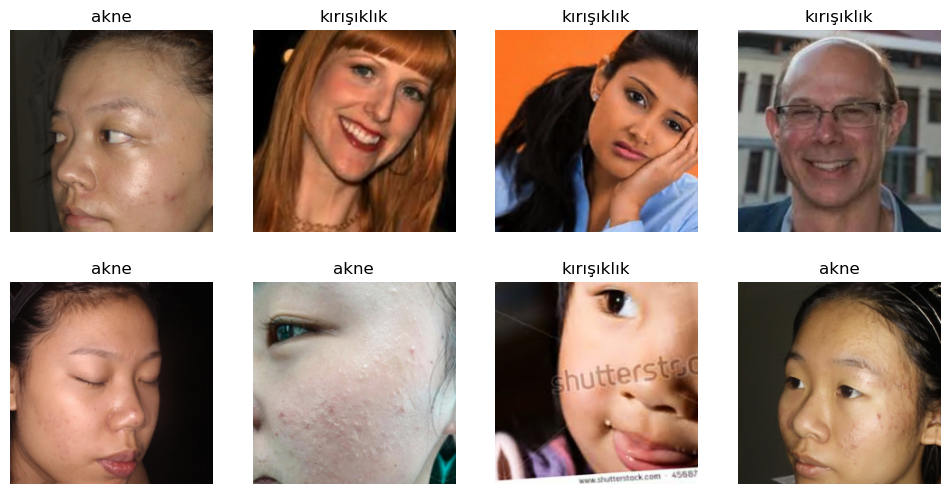

In [8]:
dls = dblock.dataloaders(all_images, bs=32)
dls.show_batch(nrows=2, ncols=4)

In [9]:
learn = vision_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.5))
learn.fine_tune(3)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.610038,0.276462,0.897024,11:03


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.320643,0.171396,0.955357,09:11
1,0.206053,0.076174,0.991667,1:21:25
2,0.147562,0.070994,0.989881,10:03


In [10]:
learn.export(base_path/"skin_model.pkl")